## Importing libraries

In [1]:
from utils import *

In [2]:
set_seed(0)

Random seed set as 0


In [3]:
X_train = np.load('./X_train.npy')
X_val = np.load('./X_val.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_val = np.load('./y_val.npy')
y_test = np.load('./y_test.npy')
unknown_redshift_data = np.load('./unknown_redshift_data.npy')

In [4]:
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

## Bayesian model training

Monte Carlo Dropout Model

In [51]:
class MonteCarloDropout(tf.keras.layers.Dropout):
  def call(self, inputs):
    return super().call(inputs, training=True)

In [52]:
mcdropout_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)),
            MonteCarloDropout(0.25),
            tf.keras.layers.Dense(1)
        ])
mcdropout_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
monte_carlo_dropout (MonteCa (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


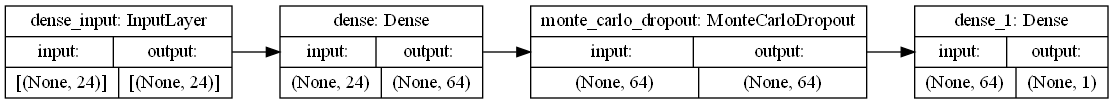

In [7]:
tf.keras.utils.plot_model(mcdropout_model, to_file='./model_architecture_images/mcdropout.png', show_shapes=True, rankdir = 'LR')

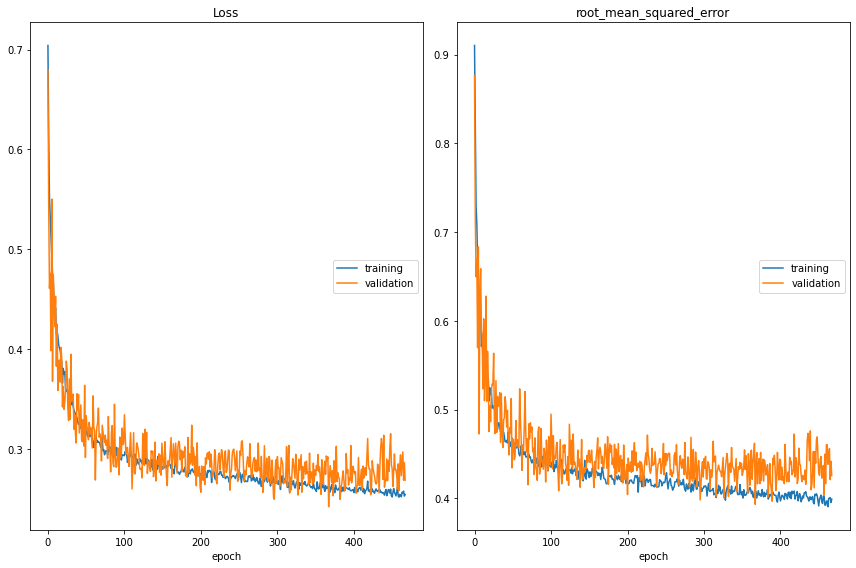

Loss
	training         	 (min:    0.252, max:    0.704, cur:    0.254)
	validation       	 (min:    0.242, max:    0.680, cur:    0.269)
root_mean_squared_error
	training         	 (min:    0.391, max:    0.910, cur:    0.399)
	validation       	 (min:    0.393, max:    0.876, cur:    0.426)

Epoch 468: val_root_mean_squared_error did not improve from 0.39325
5/5 [==============================] - 1s 162ms/step - loss: 0.2543 - root_mean_squared_error: 0.3990 - val_loss: 0.2686 - val_root_mean_squared_error: 0.4256


In [19]:
train(
    model = mcdropout_model,
    mode = 'test_mc',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

Reparameterized estimator

In [26]:
reparameterized_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.25),
            tfpl.DenseReparameterization(
                units = 1,
                kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                bias_prior_fn = tfpl.default_multivariate_normal_fn,
                bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn = divergence_fn,
                bias_divergence_fn = divergence_fn,
                activation = tf.nn.relu
            )
        ])
reparameterized_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1600      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_reparameterization_7 ( (None, 1)                 130       
Total params: 1,730
Trainable params: 1,730
Non-trainable params: 0
_________________________________________________________________


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


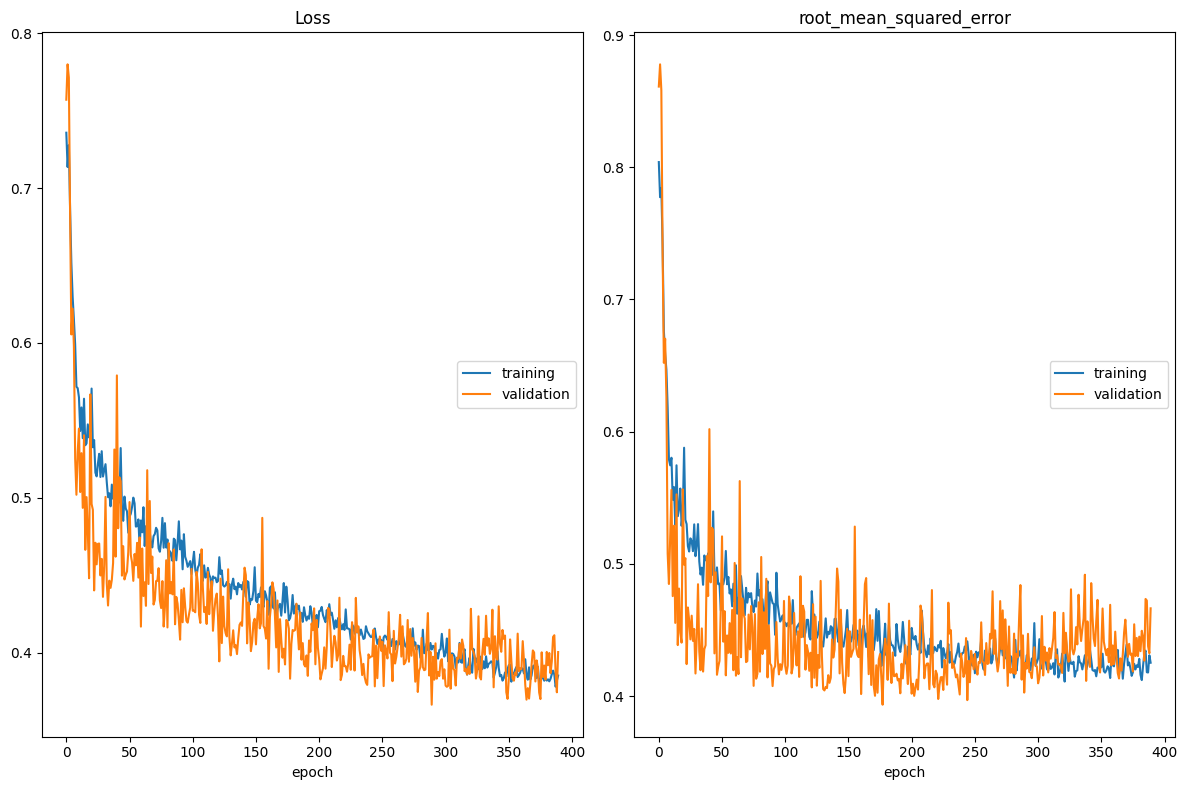

Loss
	training         	 (min:    0.378, max:    0.736, cur:    0.385)
	validation       	 (min:    0.366, max:    0.780, cur:    0.400)
root_mean_squared_error
	training         	 (min:    0.411, max:    0.804, cur:    0.425)
	validation       	 (min:    0.393, max:    0.878, cur:    0.466)

Epoch 00390: val_root_mean_squared_error did not improve from 0.39350


In [27]:
train(
    model = reparameterized_model,
    mode = 'vi_reparameterized',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

Bayesian (Variational Inference)

In [14]:
flipout_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.25),
            tfpl.DenseFlipout(
                units = 1,
                kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                bias_prior_fn = tfpl.default_multivariate_normal_fn,
                bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn = divergence_fn,
                bias_divergence_fn = divergence_fn,
                activation = tf.nn.relu
            )
        ])
flipout_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 1)                 130       
Total params: 1,730
Trainable params: 1,730
Non-trainable params: 0
_________________________________________________________________


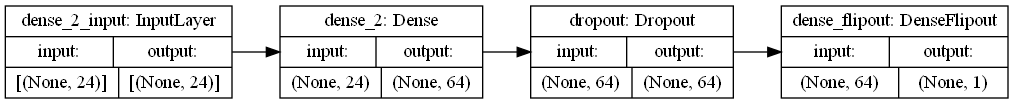

In [9]:
tf.keras.utils.plot_model(flipout_model, to_file='./model_architecture_images/vi.png', show_shapes=True, rankdir = 'LR')

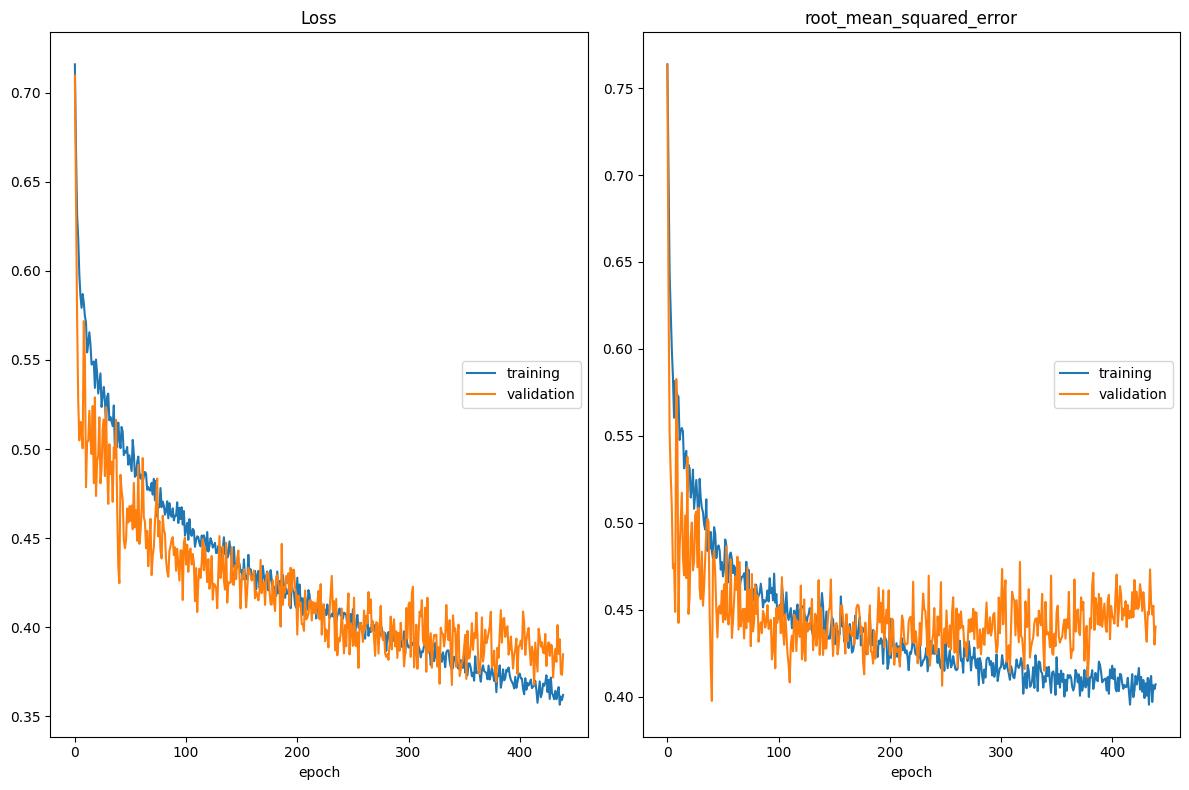

Loss
	training         	 (min:    0.356, max:    0.716, cur:    0.362)
	validation       	 (min:    0.367, max:    0.710, cur:    0.385)
root_mean_squared_error
	training         	 (min:    0.395, max:    0.764, cur:    0.407)
	validation       	 (min:    0.398, max:    0.763, cur:    0.440)

Epoch 00440: val_root_mean_squared_error did not improve from 0.39752


In [12]:
train(
    model = flipout_model,
    mode = 'test_vi_flipout',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

## Frequentist model training

In [34]:
frequentist_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)),
            tf.keras.layers.Dropout(0.25),
            tf.keras.layers.Dense(1, activation='relu')
        ])
frequentist_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                1600      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


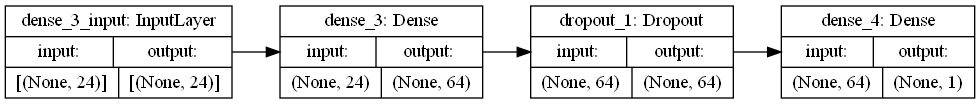

In [11]:
tf.keras.utils.plot_model(frequentist_model, to_file='./model_architecture_images/frequentist.png', show_shapes=True, rankdir = 'LR')

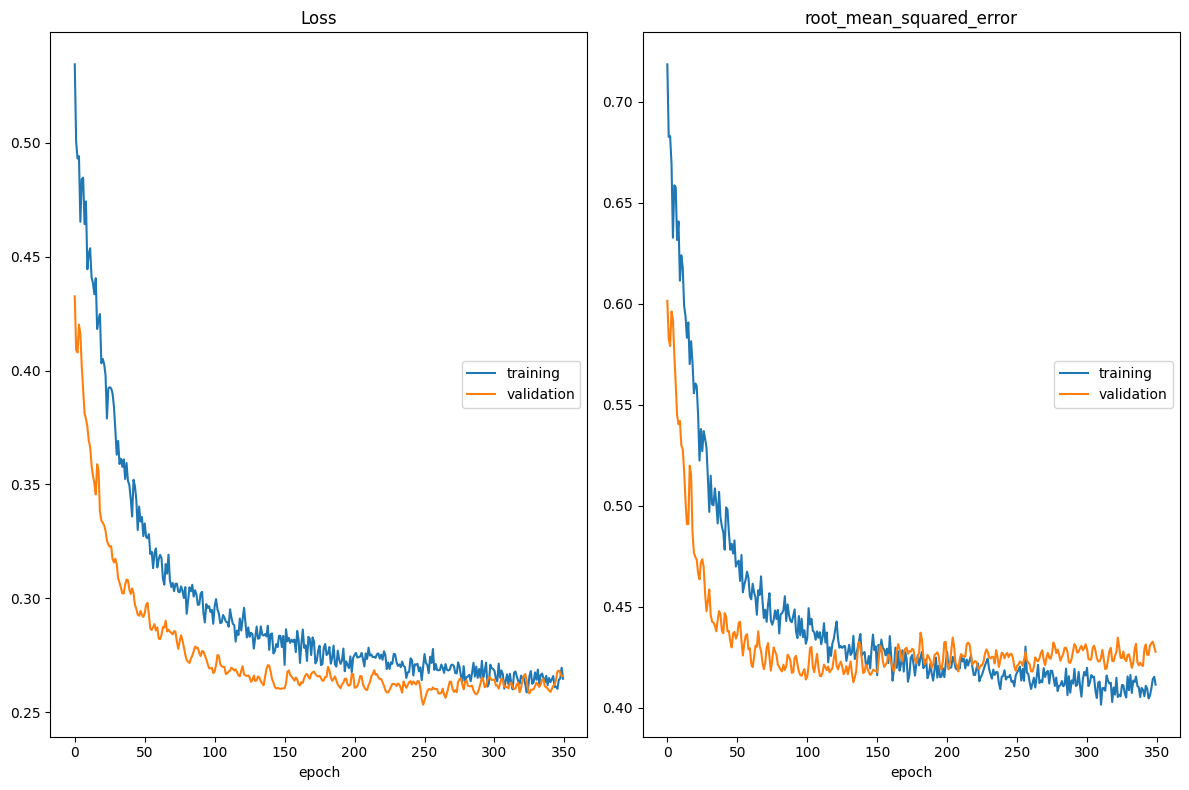

Loss
	training         	 (min:    0.259, max:    0.535, cur:    0.265)
	validation       	 (min:    0.253, max:    0.433, cur:    0.266)
root_mean_squared_error
	training         	 (min:    0.402, max:    0.718, cur:    0.412)
	validation       	 (min:    0.413, max:    0.601, cur:    0.428)

Epoch 00350: val_root_mean_squared_error did not improve from 0.41263


In [35]:
train(
    model = frequentist_model,
    mode = 'test_frequentist',
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs= 2500
)

In [40]:
def frequentist_evaluation(X_test = None, y_test = None, model = None, model_name = None, data_split = None):
    subdirname = f'{model_name}_{data_split}'
    fileloc = f'./predictions/{subdirname}'
    os.makedirs(fileloc, exist_ok=True)
    filename = {
        'csv' : fileloc+'/predictions.csv',
        'npy' : fileloc+'/prediction_array.npy'
    }
    y_pred = model.predict(X_test)
    corr_coeff = np.corrcoef(np.array(y_test).reshape(-1), y_pred.reshape(-1))[0,1]
    r2_value = r2_score(y_test, y_pred) 
    rmse_value = mean_squared_error(y_test, y_pred, squared = False)


    df = pd.read_csv(f'./{data_split}_samples.csv')
    df['Redshift_preds'] = list(np.squeeze(y_pred))
    df.to_csv(fileloc+'/preds_with_features.csv', index=False)
    generate_csv(
        y_test_list= list(y_test),
        mean_predictions=list(np.squeeze(y_pred)),
        std_predictions=list(np.squeeze(np.zeros(y_pred.shape))),
        filename=filename['csv']
    )
    np.save(filename['npy'], y_pred)

    print(f'RMSE = {rmse_value}')
    print(f'R^2 = {r2_value}')
    print(f'Correlation = {corr_coeff}')

## Frequentist evaluation

In [41]:
frequentist_model.load_weights('./checkpoints_test_frequentist/best')
frequentist_evaluation(
    X_test = X_test,
    y_test = y_test,
    model = frequentist_model,
    model_name = 'frequentist',
    data_split='test'
)

RMSE = 0.3982967138290405
R^2 = 0.5530933481039636
Correlation = 0.7880154059591313


In [42]:
frequentist_model.load_weights('./checkpoints_test_frequentist/best')

for X, y, data_split in [[X_train, y_train, 'train'], [X_val, y_val, 'val']]:
    frequentist_evaluation(
        X_test = X,
        y_test = y,
        model = frequentist_model,
        model_name = 'frequentist',
        data_split = data_split
    )

RMSE = 0.40948888659477234
R^2 = 0.46252098551316045
Correlation = 0.6865325697973819
RMSE = 0.4126319885253906
R^2 = 0.5479268532646754
Correlation = 0.7474297889258936


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

def compare_real_and_predicted_redshifts(model_name=None, no_of_bins=None):
    dirname = 'predictions'
    train_file = f'./{dirname}/{model_name}_train/predictions.csv'
    val_file = f'./{dirname}/{model_name}_val/predictions.csv'
    test_file = f'./{dirname}/{model_name}_test/predictions.csv'
    preds_with_features_file_test = f'./{dirname}/{model_name}_test/preds_with_features.csv'
    preds_with_features_file_val = f'./{dirname}/{model_name}_val/preds_with_features.csv'
    preds_with_features_file_train = f'./{dirname}/{model_name}_train/preds_with_features.csv' 

    # Load predictions from train, validation, and test files
    df_train = pd.read_csv(train_file)
    df_val = pd.read_csv(val_file)
    df_test = pd.read_csv(test_file)

    # Concatenate the dataframes into one
    df = pd.concat([df_train, df_val, df_test], ignore_index=True)

    real_redshifts = df['true_value']
    predictions = df['mean']

    # Set seaborn darkgrid style
    sns.set(style="darkgrid")

    # Calculate histograms
    hist_predictions, bin_edges_preds = np.histogram(predictions, bins=no_of_bins, density=True)
    hist_real_redshifts, bin_edges_gt = np.histogram(real_redshifts, bins=no_of_bins, density=True)

    # Normalize histograms
    hist_predictions_norm = hist_predictions / np.sum(hist_predictions)
    hist_real_redshifts_norm = hist_real_redshifts / np.sum(hist_real_redshifts)

    # Set larger figure size
    plt.figure(figsize=(12, 6))

    # Plot normalized histograms using plt.bar
    bar_width_preds = bin_edges_preds[1] - bin_edges_preds[0]
    bar_width_gt = bin_edges_gt[1] - bin_edges_gt[0]
    bin_centers_preds = bin_edges_preds[:-1] + bar_width_preds / 2
    bin_centers_gt = bin_edges_gt[:-1] + bar_width_gt/2

    plt.bar(bin_centers_preds, hist_predictions_norm, width=bar_width_preds, alpha=0.6, color='tab:blue', label='Predictions')
    plt.bar(bin_centers_gt, hist_real_redshifts_norm, width=bar_width_gt, alpha=0.3, color='red', label='Real Redshifts')
    plt.xticks(np.arange(0, 4.25, 0.25))  # Set x-axis tick values
    plt.xlabel('Redshift')
    plt.ylabel('Normalized Frequency')
    plt.title('Distributions of Real Redshifts and Predictions')
    plt.legend()
    plt.show()

    # Add subplot for the Gaussian distributions
    known_redshift_file = 'known_redshift_samples.csv'
    preds_with_features_df_train = pd.read_csv(preds_with_features_file_train)
    preds_with_features_df_val = pd.read_csv(preds_with_features_file_val)
    preds_with_features_df_test = pd.read_csv(preds_with_features_file_test)
    preds_with_features_df = pd.concat([preds_with_features_df_train, preds_with_features_df_val, preds_with_features_df_test], ignore_index=True)
    df_known_redshifts = pd.read_csv(known_redshift_file)
    classes_to_plot = ['BLL', 'FSRQ', 'BCU']

    plt.subplot(2, 2, 1)  # Create a 2x2 grid of subplots, and set the first subplot as active
    for cls in classes_to_plot:
        # Filter data for the current class
        class_data= preds_with_features_df[preds_with_features_df['CLASS'] == cls]['Redshift_preds']

        # Calculate histogram and normalize for the current class
        hist_cls, cls_bin_edges = np.histogram(class_data, bins=200, density=True)
        hist_cls_norm = hist_cls / np.sum(hist_cls)

        cls_bar_width = cls_bin_edges[1] - cls_bin_edges[0]
        cls_bin_centers = cls_bin_edges[:-1] + cls_bar_width / 2

        # Fit a Gaussian distribution using curve_fit
        params, _ = curve_fit(gaussian, cls_bin_centers, hist_cls_norm, p0=[np.mean(class_data), 1.0, 1.0])
        fitted_pdf = gaussian(cls_bin_centers, *params)

        # Plot the fitted Gaussian curve
        plt.plot(cls_bin_centers, fitted_pdf, label=cls)

    plt.xlabel('Redshift')
    plt.ylabel('Probability Density')
    plt.title('Distribution of Predictions (by CLASS)')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

    plt.subplot(2, 2, 4)  # Create a 2x2 grid of subplots, and set the first subplot as active
    for cls in classes_to_plot:
        # Filter data for the current class
        class_data_known = df_known_redshifts[df_known_redshifts['CLASS'] == cls]['Redshift']
        #merged_df = df[df['true_value'].isin(class_data_known)].merge(df_known_redshifts, left_on='true_value', right_on='Redshift', how='inner')
        #class_data = merged_df['mean']

        # Calculate histogram and normalize for the current class
        hist_cls, cls_bin_edges = np.histogram(class_data_known, bins=200, density=True)
        hist_cls_norm = hist_cls / np.sum(hist_cls)

        cls_bar_width = cls_bin_edges[1] - cls_bin_edges[0]
        cls_bin_centers = cls_bin_edges[:-1] + cls_bar_width / 2

        # Fit a Gaussian distribution using curve_fit
        params, _ = curve_fit(gaussian, cls_bin_centers, hist_cls_norm, p0=[np.mean(class_data_known), 1.0, 1.0])
        fitted_pdf = gaussian(cls_bin_centers, *params)

        # Plot the fitted Gaussian curve
        plt.plot(cls_bin_centers, fitted_pdf, label=cls)

    plt.xlabel('Redshift')
    plt.ylabel('Probability Density')
    plt.title('Distribution of Known Redshifts (by CLASS)')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

    print(f'Mean is {np.mean(predictions)}, max is {np.max(predictions)} and min is {np.min(predictions)}')

# Example usage:
# compare_real_and_predicted_redshifts(model_name='my_model', no_of_bins=100)  # Use a higher number of bins


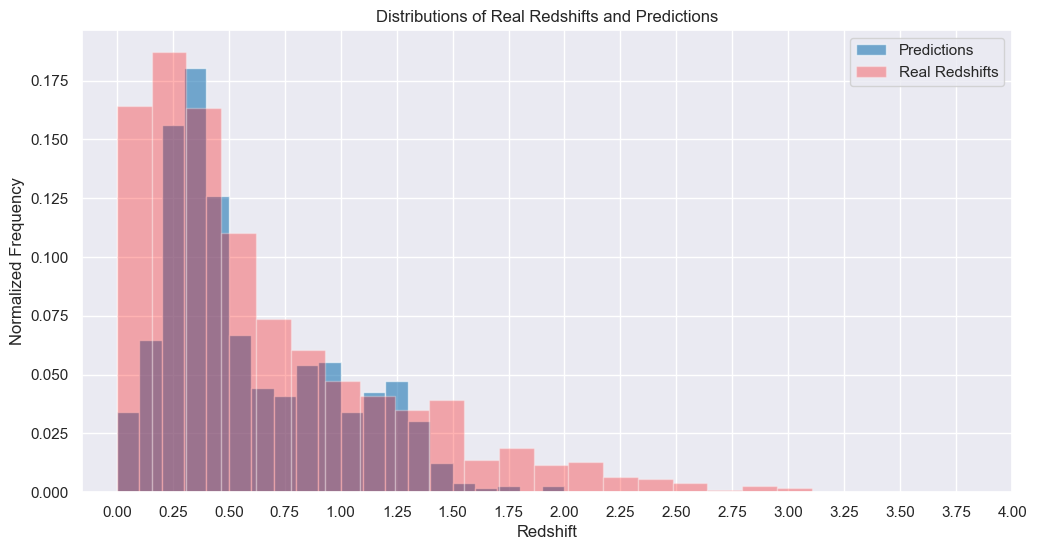

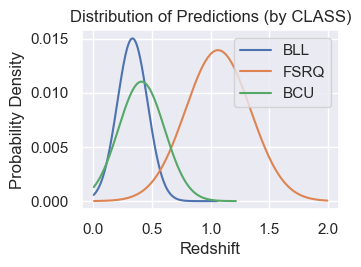

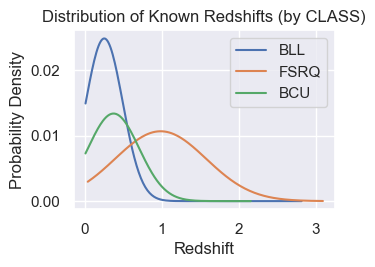

Mean is 0.5853782485265523, max is 1.9997013 and min is 0.0


In [21]:
compare_real_and_predicted_redshifts(
    model_name='frequentist',
    no_of_bins=20
)

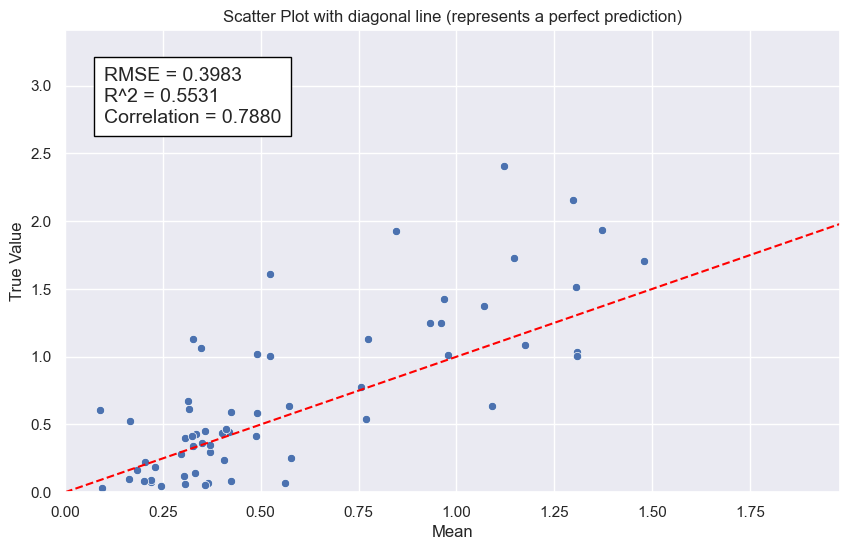

In [49]:
plot_scatter_plot(
    model_name='frequentist',
    data_split='test'
)

## Bayesian ensembled evaluation


We evaluate each sample 1000 times and calculate the &mu; and &sigma; for the 1000 predictions. If 3&sigma; > threshold, then we refuse to make a prediction for that sample, else the &mu; value happens to be the final prediction for that sample

Monte carlo bayesian model:

In [9]:
mcdropout_model.load_weights('./checkpoints_test_mc/best')
ensembled_evaluation(
    X_test=X_test,
    y_test = y_test,
    model = mcdropout_model,
    ensemble_size= 1000,
    thresholds= [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 1],
    pred_mode='mean',
    model_name = 'mcdropout',
    data_split = 'test'
)

100%|██████████| 1000/1000 [00:33<00:00, 29.98it/s]


For 0.4:
Samples predicted = 82.25806451612904
RMSE = 0.3538572795802334
R^2 = 0.46031309361431616
Correlation = 0.7842459668803505

For 0.45:
Samples predicted = 85.48387096774194
RMSE = 0.392485688785811
R^2 = 0.4709525056880798
Correlation = 0.8148962835065403

For 0.5:
Samples predicted = 90.32258064516128
RMSE = 0.3997097108205257
R^2 = 0.522370900964461
Correlation = 0.8323731829224993

For 0.55:
Samples predicted = 93.54838709677419
RMSE = 0.40876673546584974
R^2 = 0.5262949190258228
Correlation = 0.8270631966010942

For 0.6:
Samples predicted = 96.7741935483871
RMSE = 0.4105698615722108
R^2 = 0.5150514579265584
Correlation = 0.8068764499928875

For 0.65:
Samples predicted = 98.38709677419355
RMSE = 0.40752349116347025
R^2 = 0.5167307798351379
Correlation = 0.7988592809261156

For 0.7:
Samples predicted = 100.0
RMSE = 0.4052401770870188
R^2 = 0.5373757008999911
Correlation = 0.8068968520014422

For 0.75:
Samples predicted = 100.0
RMSE = 0.4052401770870188
R^2 = 0.53737570089999

MVN distribution Bayesian model:

In [15]:
flipout_model.load_weights('./checkpoints_test_vi/best')
ensembled_evaluation(
    X_test=X_test,
    y_test = y_test,
    model = flipout_model,
    ensemble_size= 1000,
    thresholds= [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 1],
    pred_mode='mean',
    model_name = 'vi',
    data_split = 'test'
) 

100%|██████████| 1000/1000 [00:32<00:00, 30.46it/s]


For 0.4:
Samples predicted = 88.70967741935483
RMSE = 0.3907151444368996
R^2 = 0.4897870047534666
Correlation = 0.7754890459802786

For 0.45:
Samples predicted = 95.16129032258065
RMSE = 0.39546700817683017
R^2 = 0.5143513880299999
Correlation = 0.7658885490951877

For 0.5:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 0.55:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 0.6:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 0.65:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 0.7:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 0.75:
Samples predicted = 100.0
RMSE = 0.40576754144020966
R^2 = 0.5361708336346698
Correlation = 0.7768165756657995

For 

In [8]:
flipout_model.load_weights('./checkpoints_test_vi_flipout/best')
ensembled_evaluation(
    X_test=X_test,
    y_test = y_test,
    model = flipout_model,
    ensemble_size= 1000,
    thresholds= [0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.90, 0.95, 1],
    pred_mode='mean',
    model_name = 'vi_flipout',
    data_split = 'test'
) 

100%|██████████| 1000/1000 [00:33<00:00, 30.27it/s]


For 0.4:
Samples predicted = 83.87096774193549
RMSE = 0.3804332852480369
R^2 = 0.4239866894258697
Correlation = 0.745692930554566

For 0.45:
Samples predicted = 90.32258064516128
RMSE = 0.4075147306380731
R^2 = 0.41202379781659193
Correlation = 0.7164833524137284

For 0.5:
Samples predicted = 98.38709677419355
RMSE = 0.41252735515035754
R^2 = 0.5195062922678004
Correlation = 0.7879610013464652

For 0.55:
Samples predicted = 98.38709677419355
RMSE = 0.41252735515035754
R^2 = 0.5195062922678004
Correlation = 0.7879610013464652

For 0.6:
Samples predicted = 98.38709677419355
RMSE = 0.41252735515035754
R^2 = 0.5195062922678004
Correlation = 0.7879610013464652

For 0.65:
Samples predicted = 100.0
RMSE = 0.41981622405161967
R^2 = 0.5034969925472671
Correlation = 0.7655269348025648

For 0.7:
Samples predicted = 100.0
RMSE = 0.41981622405161967
R^2 = 0.5034969925472671
Correlation = 0.7655269348025648

For 0.75:
Samples predicted = 100.0
RMSE = 0.41981622405161967
R^2 = 0.5034969925472671
Cor

Reparameterized estimator

In [28]:
reparameterized_model.load_weights('./checkpoints_vi_reparameterized/best')
ensembled_evaluation(
    X_test=X_test,
    y_test = y_test,
    model = reparameterized_model,
    ensemble_size= 1000,
    thresholds= [3],
    pred_mode='mean',
    model_name = 'vi_reparameterized',
    data_split = 'test'
) 

100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]


For 3:
Samples predicted = 100.0
RMSE = 0.437646532173558
R^2 = 0.4604267258493612
Correlation = 0.7779016342952105


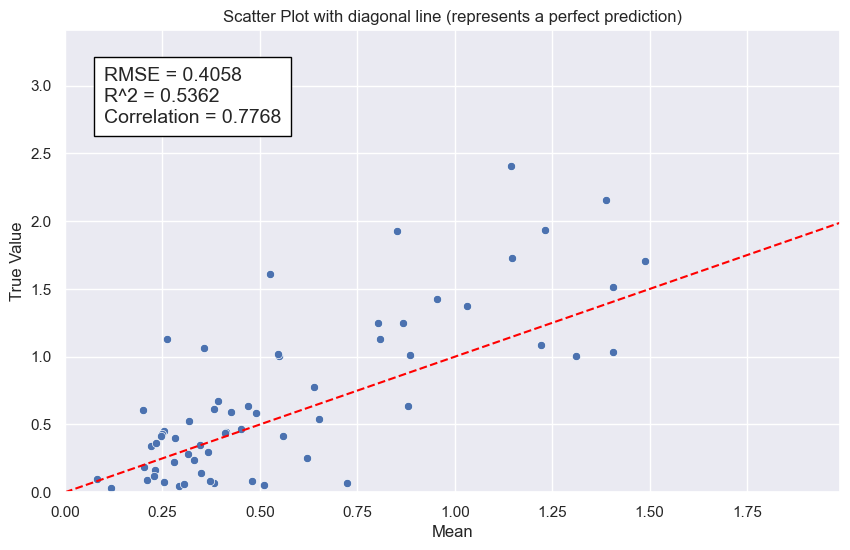

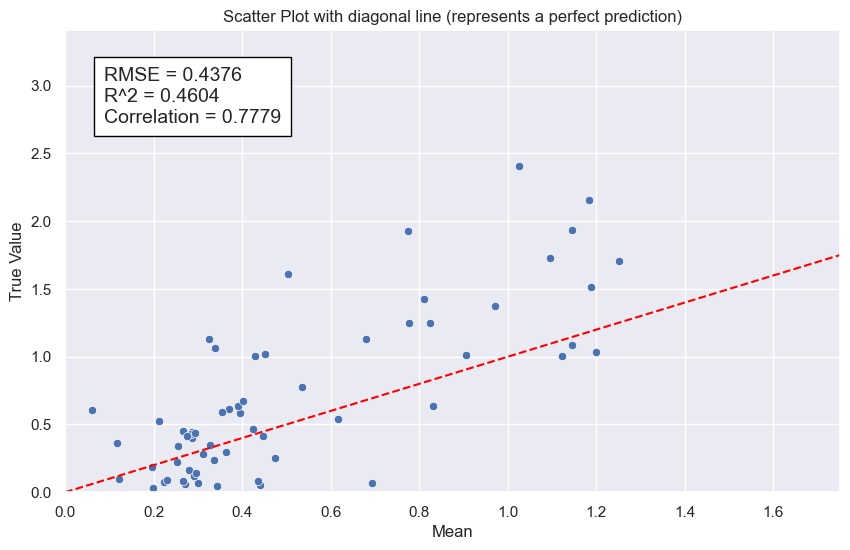

In [54]:
for file in [['vi', 'test'], ['vi_reparameterized', 'test']]:
    plot_scatter_plot(
        model_name = file[0],
        data_split = file[1]
    )

In [56]:
flipout_model.load_weights('./checkpoints_test_vi/best')
reparameterized_model.load_weights('./checkpoints_vi_reparameterized/best')
frequentist_model.load_weights('./checkpoints_test_frequentist/best')
for model in [[flipout_model, 'vi'], [frequentist_model, 'frequentist'], [reparameterized_model, 'vi_reparameterized']]:
    if model[1] == 'frequentist':
        ensemble_size = 1
    else:
        ensemble_size = 1000
    unknown_predictions(
        data = unknown_redshift_data,
        model = model[0],
        ensemble_size = ensemble_size,
        model_name = model[1] 
    )


c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\numpy\lib\stride_tricks.py:256: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


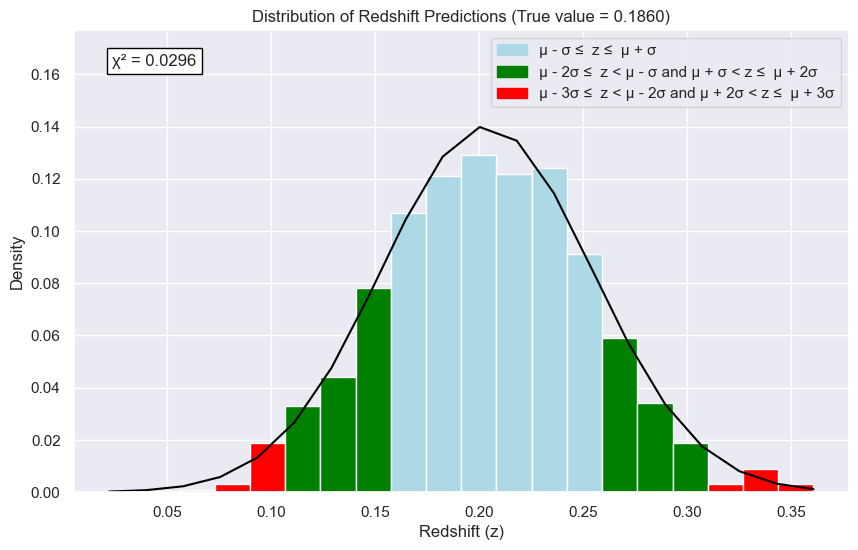

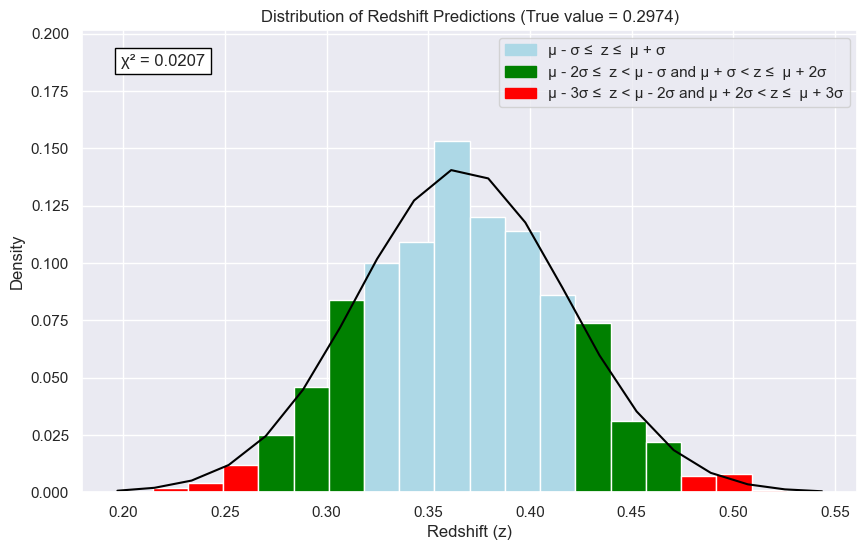

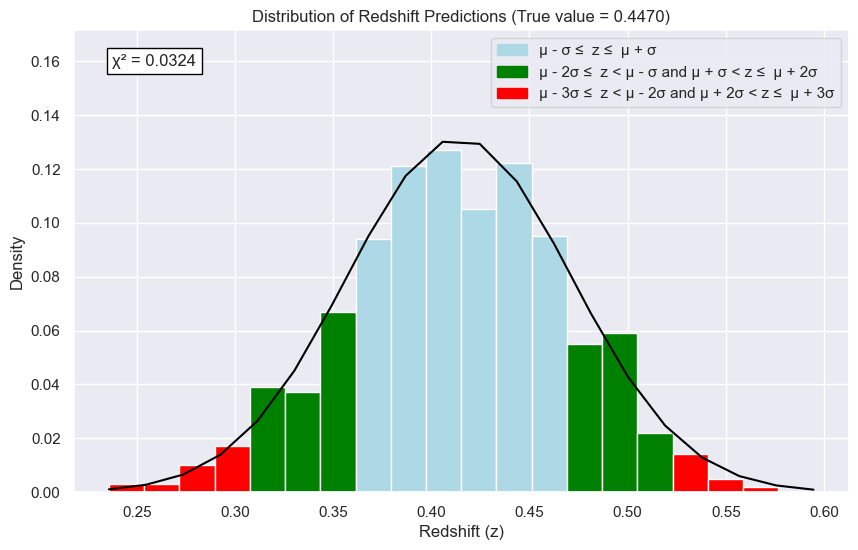

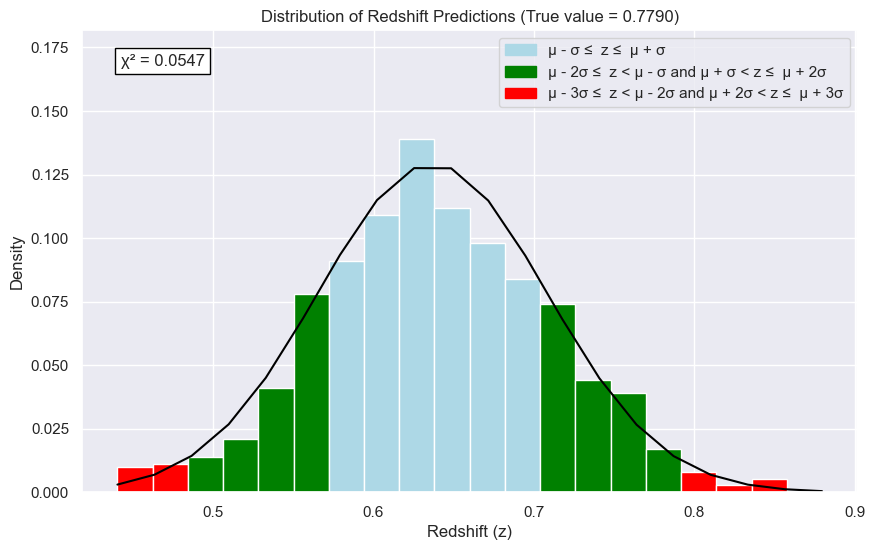

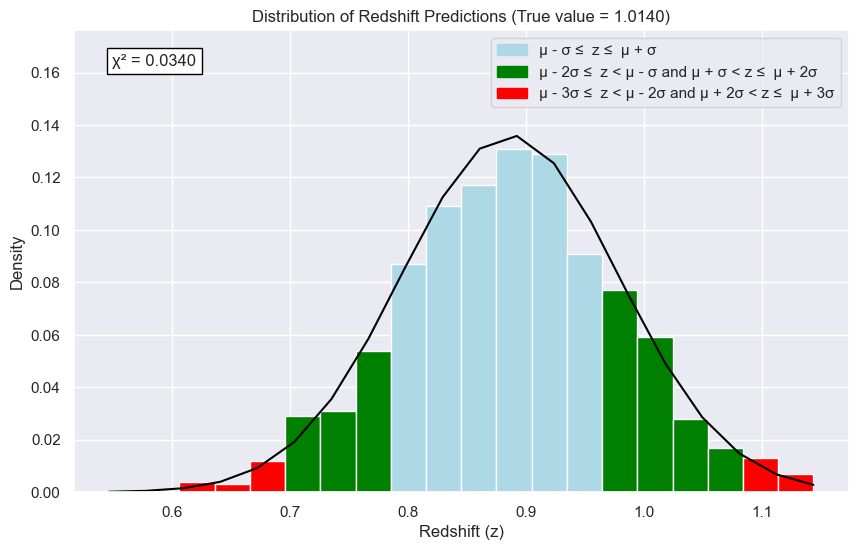

In [57]:
for sample_idx in [11, 21, 3, 20, 43]:
    plot_sample_distribution(
        model_name = 'vi',
        sample_idx = sample_idx,
        y_test = y_test,
        data_split ='test',
        no_of_bins = 20
    )

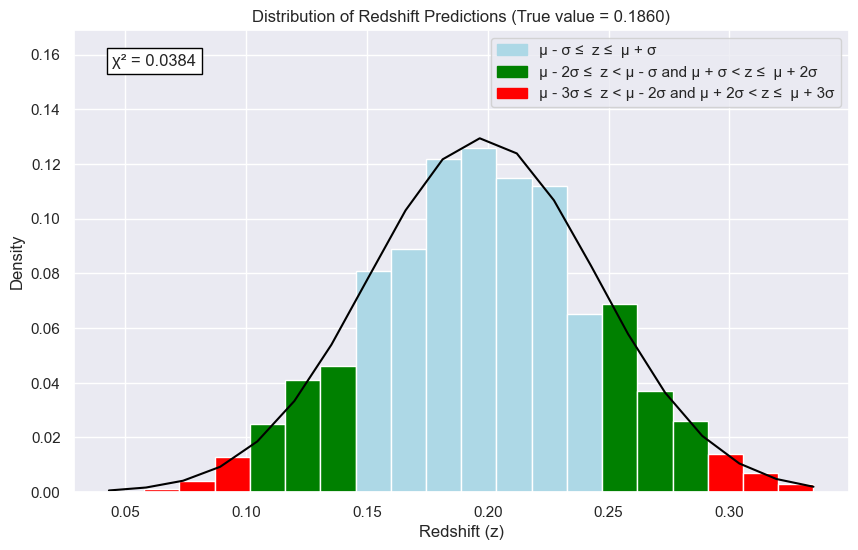

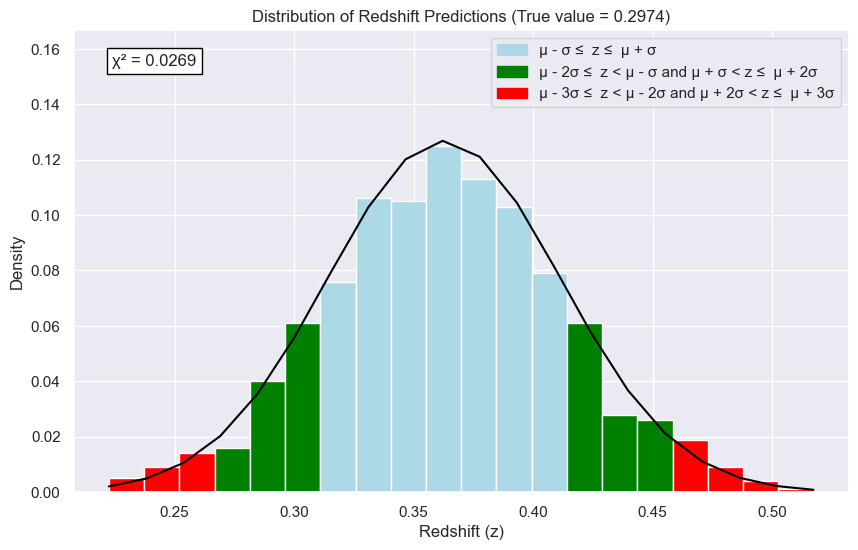

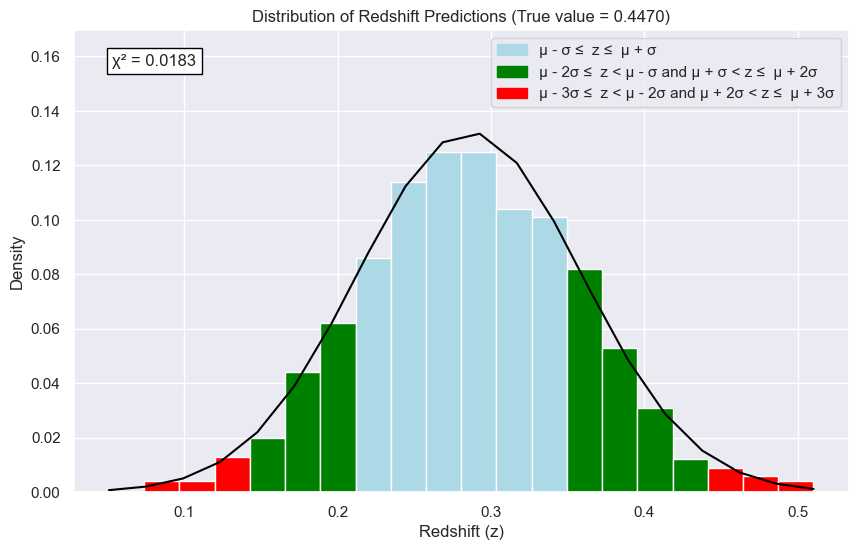

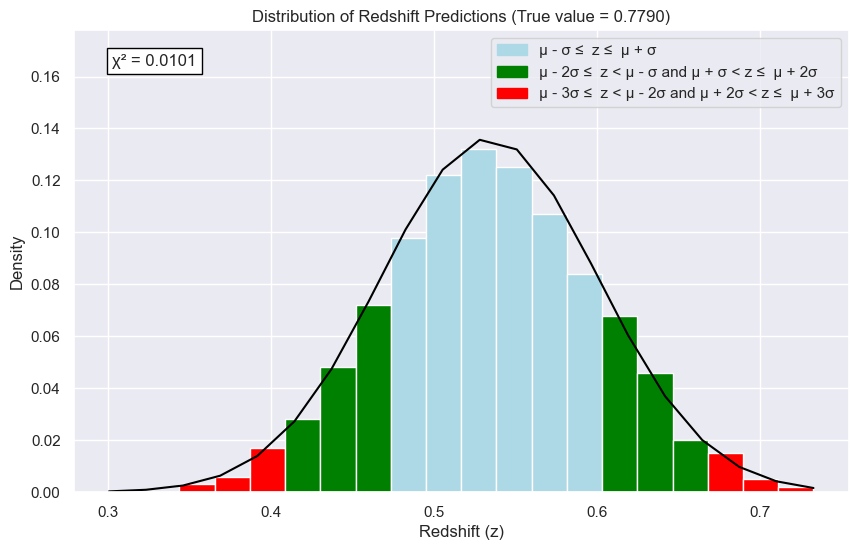

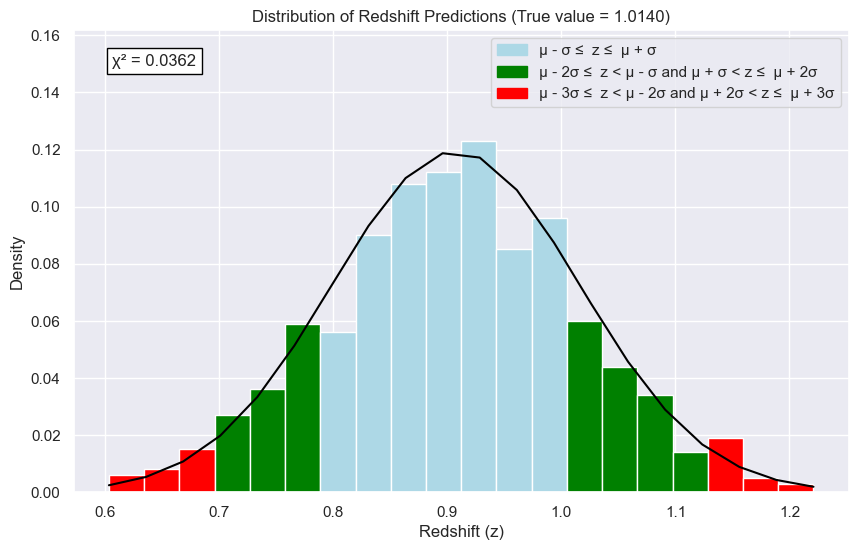

In [58]:
for sample_idx in [11, 21, 3, 20, 43]:
    plot_sample_distribution(
        model_name = 'vi_reparameterized',
        sample_idx = sample_idx,
        y_test = y_test,
        data_split ='test',
        no_of_bins = 20
    )

In [59]:
flipout_model.load_weights('./checkpoints_test_vi/best')
reparameterized_model.load_weights('./checkpoints_vi_reparameterized/best')
for model, model_name in [[flipout_model,'vi'], [reparameterized_model, 'vi_reparameterized']]:
    ensembled_evaluation(
        X_test = X_train,
        y_test = y_train,
        model = model,
        ensemble_size = 1000,
        thresholds = [2],
        pred_mode = 'mean',
        model_name = model_name,
        data_split = 'train'
    )
    ensembled_evaluation(
        X_test = X_val,
        y_test = y_val,
        model = model,
        ensemble_size = 1000,
        thresholds = [2],
        pred_mode = 'mean',
        model_name = model_name,
        data_split = 'val'
    )

100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]



For 2:
Samples predicted = 100.0
RMSE = 0.4102682985967678
R^2 = 0.4604730184948951
Correlation = 0.6864313580118675


100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]



For 2:
Samples predicted = 100.0
RMSE = 0.4090358771232072
R^2 = 0.5557722205776002
Correlation = 0.7522212313156186


100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]



For 2:
Samples predicted = 100.0
RMSE = 0.42685635638800257
R^2 = 0.41596247262728236
Correlation = 0.6808991552816466


100%|██████████| 1000/1000 [00:35<00:00, 27.94it/s]


For 2:
Samples predicted = 100.0
RMSE = 0.42586146755367876
R^2 = 0.5184741555597927
Correlation = 0.7618455020460764


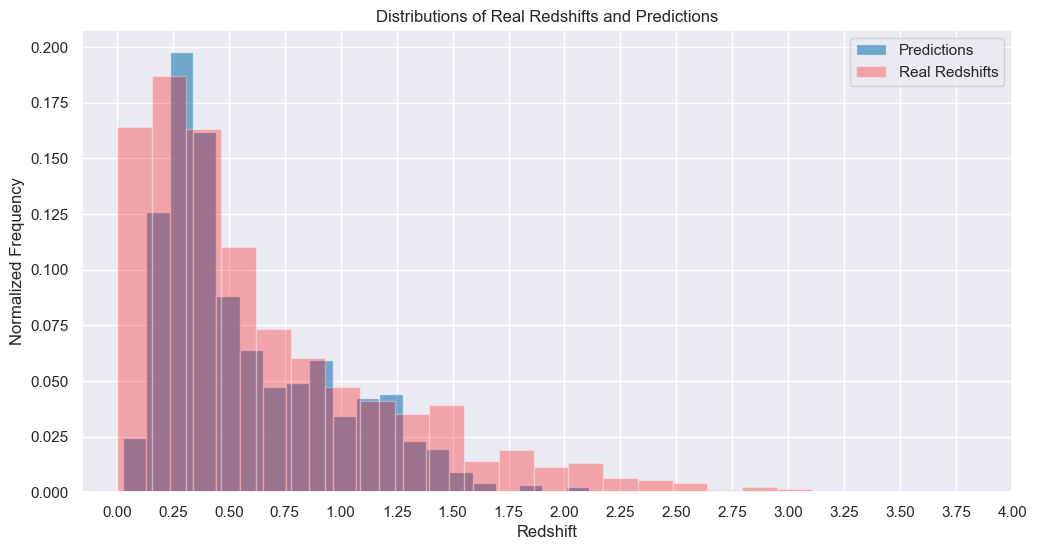

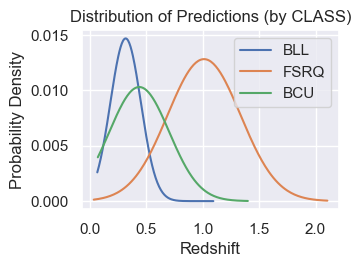

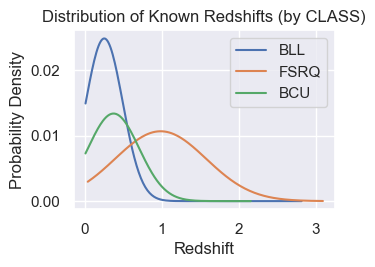

Mean is 0.5806266032653965, max is 2.109389235496521 and min is 0.0278637918457388


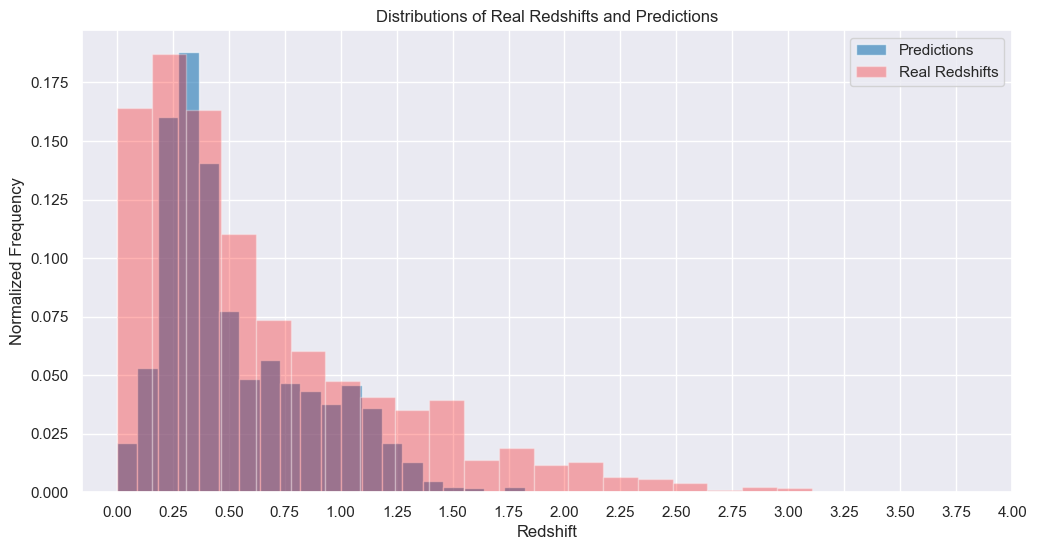

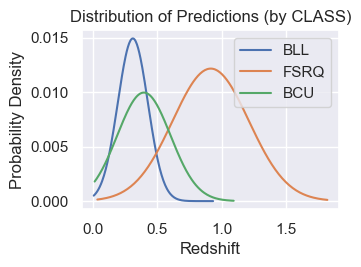

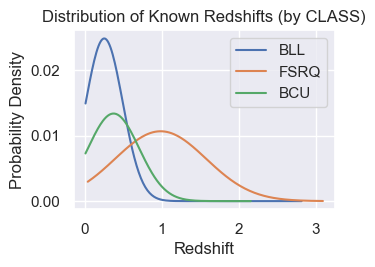

Mean is 0.5263733268933815, max is 1.8225131274461743 and min is 0.0004336096644401


In [22]:
compare_real_and_predicted_redshifts(
    model_name='vi',
    no_of_bins=20
)
compare_real_and_predicted_redshifts(
    model_name='vi_reparameterized',
    no_of_bins=20
)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp(- (x - mean)**2 / (2 * standard_deviation ** 2))

def compare_known_and_unknown_redshifts(model_name=None, no_of_bins=None):
    dirname = 'predictions'
    train_file = f'./{dirname}/{model_name}_train/predictions.csv'
    val_file = f'./{dirname}/{model_name}_val/predictions.csv'
    test_file = f'./{dirname}/{model_name}_test/predictions.csv'
    unknown_reshift_file = f'./{dirname}/{model_name}_unknown_redshift/predictions.csv'

    # Load predictions from train, validation, and test files
    df_train = pd.read_csv(train_file)
    df_val = pd.read_csv(val_file)
    df_test = pd.read_csv(test_file)
    unknown_redshift_df = pd.read_csv(unknown_reshift_file)

    # Concatenate the dataframes into one
    df = pd.concat([df_train, df_val, df_test], ignore_index=True)

    known_redshifts = df['true_value']
    unknown_redshift_predictions = unknown_redshift_df['Redshift_mean']

    # Set seaborn darkgrid style
    sns.set(style="darkgrid")

    # Calculate histograms
    hist_predictions, bin_edges_unknown = np.histogram(unknown_redshift_predictions, bins=no_of_bins, density=True)
    hist_real_redshifts, bin_edges_known = np.histogram(known_redshifts, bins=no_of_bins, density=True)

    # Normalize histograms
    hist_predictions_norm = hist_predictions / np.sum(hist_predictions)
    hist_real_redshifts_norm = hist_real_redshifts / np.sum(hist_real_redshifts)

    # Set larger figure size
    plt.figure(figsize=(12, 6))

    # Plot normalized histograms using plt.bar
    bar_width_unknown = bin_edges_unknown[1] - bin_edges_unknown[0]
    bin_centers_unknown = bin_edges_unknown[:-1] + bar_width_unknown / 2
    bar_width_known = bin_edges_known[1] - bin_edges_known[0]
    bin_centers_known = bin_edges_known[:-1] + bar_width_known/2

    plt.bar(bin_centers_unknown, hist_predictions_norm, width=bar_width_unknown, alpha=0.6, color='tab:blue', label='Predictions for Unknown Redshift Samples')
    plt.bar(bin_centers_known, hist_real_redshifts_norm, width=bar_width_known, alpha=0.3, color='red', label='Known Redshifts')
    plt.xticks(np.arange(0, 4.25, 0.25))  # Set x-axis tick values
    plt.xlabel('Redshift')
    plt.ylabel('Normalized Frequency')
    plt.title('Distributions of Known Redshifts and Predictions made on Unknown Redshift Samples')
    plt.legend()
    plt.show()

    # Add subplot for the Gaussian distributions
    classes_to_plot = ['BLL', 'BCU']

    plt.subplot(2, 2, 1)  # Create a 2x2 grid of subplots, and set the first subplot as active
    for cls in classes_to_plot:
        # Filter data for the current class
        class_data = unknown_redshift_df[unknown_redshift_df['CLASS'] == cls]['Redshift_mean']
        # Calculate histogram and normalize
        hist_cls, cls_bin_edges = np.histogram(class_data, bins=60, density=True)
        hist_cls_norm = hist_cls / np.sum(hist_cls)
     
        cls_bar_width = cls_bin_edges[1] - cls_bin_edges[0]
        cls_bin_centers = cls_bin_edges[:-1] + cls_bar_width / 2
        
        # Fit a Gaussian distribution using curve_fit
        params, _ = curve_fit(gaussian, cls_bin_centers, hist_cls_norm, p0=[np.mean(class_data), 1.0, 1.0])
        fitted_pdf = gaussian(cls_bin_centers, *params)
        
        # Plot the fitted Gaussian curve
        plt.plot(cls_bin_centers, fitted_pdf, label=cls)
    
    plt.xlabel('Redshift')
    plt.ylabel('Probability Density')
    plt.title('Distributions for predictions on \nunknown redshift samples (by CLASS)')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

    print(f'Mean is {np.mean(unknown_redshift_predictions)}, max is {np.max(unknown_redshift_predictions)} and min is {np.min(unknown_redshift_predictions)}')

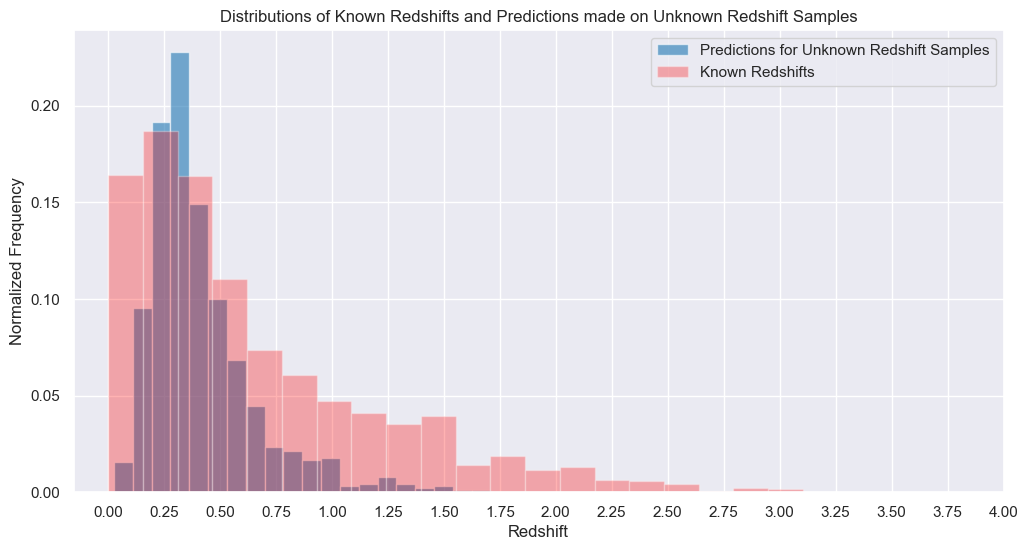

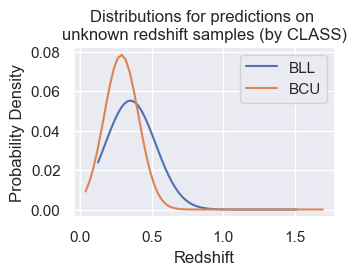

Mean is 0.4145693647332203, max is 1.7083286546468734 and min is 0.0251047026515007


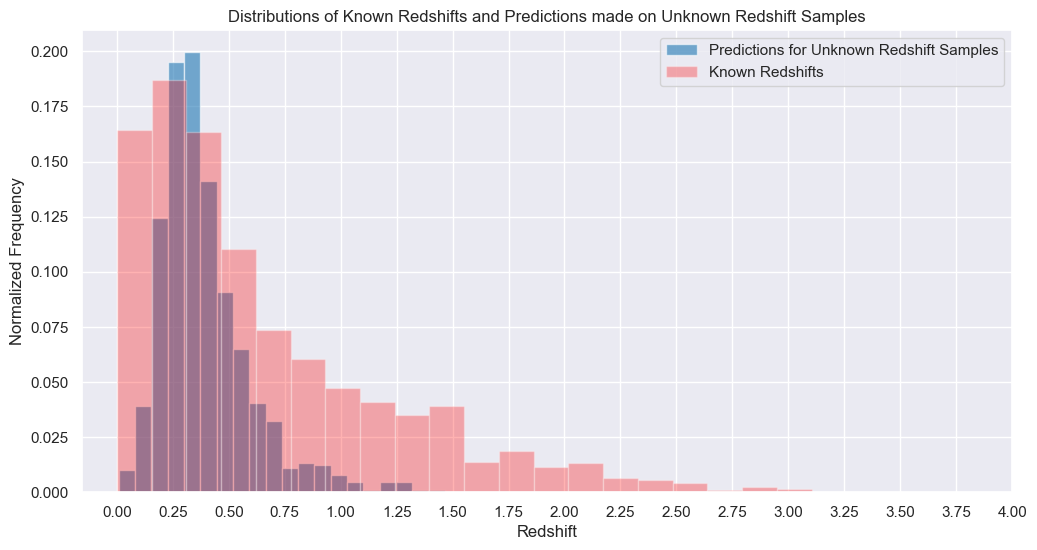

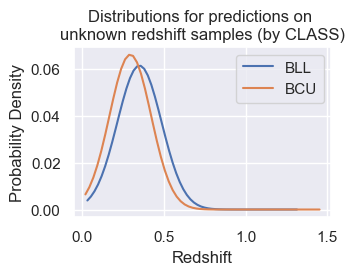

Mean is 0.39271234489925366, max is 1.4650525957345963 and min is 0.0089332999289035


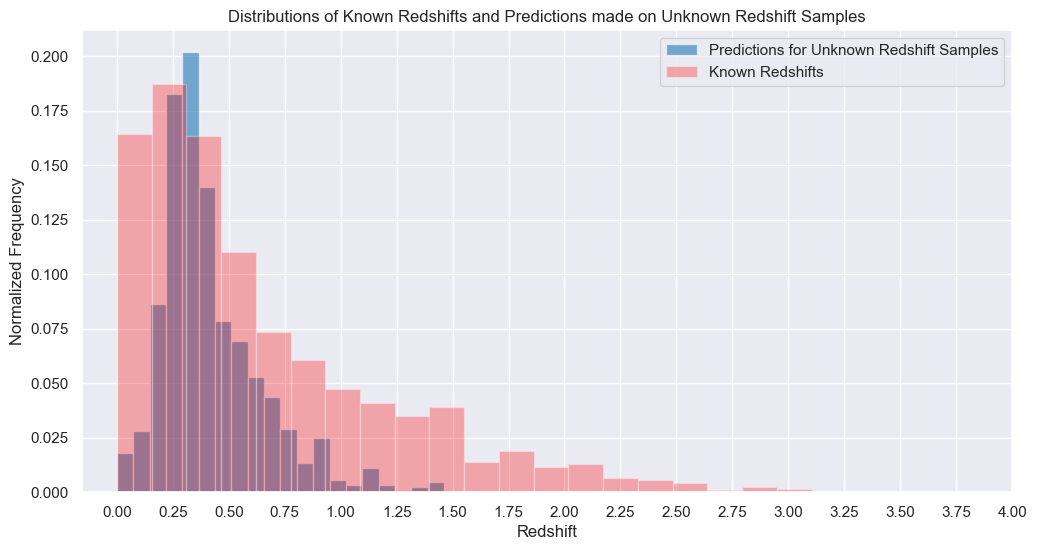

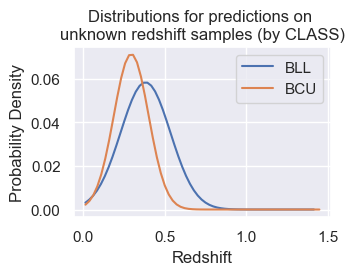

Mean is 0.42146560342589834, max is 1.4621115922927856 and min is 0.0


In [24]:
compare_known_and_unknown_redshifts(
    model_name='vi',
    no_of_bins=20
)
compare_known_and_unknown_redshifts(
    model_name='vi_reparameterized',
    no_of_bins=20
)
compare_known_and_unknown_redshifts(
    model_name='frequentist',
    no_of_bins=20
)

Uncertainty Calibration Error (UCE): 0.15713663253751742


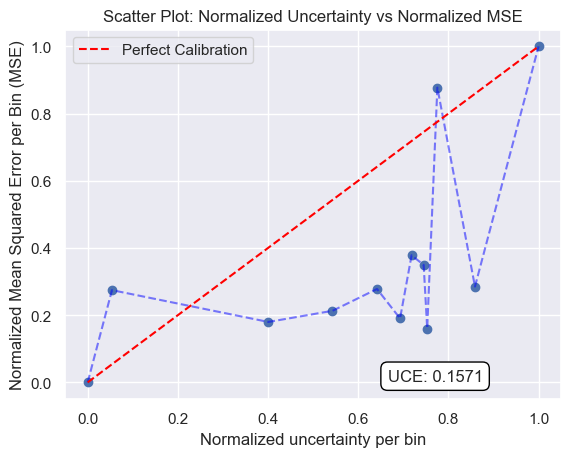

Uncertainty Calibration Error (UCE): 0.18391744018029155


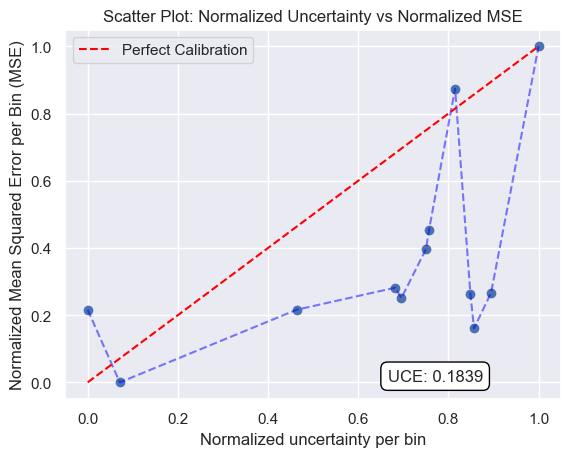

In [76]:
plot_uncertainty_calibration(
    no_of_bins=12, 
    model_name='vi', 
    data_split='test'
)
plot_uncertainty_calibration(
    no_of_bins=12, 
    model_name='vi_reparameterized', 
    data_split='test'
)

In [26]:
import pandas as pd

def calculate_mean_variance(csv_file):
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)

    # Calculate the variance column as (std)^2
    data['variance'] = data['std'] ** 2

    # Compute the mean variance
    mean_variance = data['variance'].mean()

    return mean_variance

# Example usage:
csv_file_path = "predictions\\vi_reparameterized_test\\predictions.csv"
mean_variance_result = calculate_mean_variance(csv_file_path)
print("Reparameterized Mean Variance:", mean_variance_result)

csv_file_path = "predictions\\vi_test\\predictions.csv"
mean_variance_result = calculate_mean_variance(csv_file_path)
print("Mean Variance:", mean_variance_result)

Reparameterized Mean Variance: 0.007617047109463515
Mean Variance: 0.007510666214868823


In [27]:
def calculate_mean_variance(model_name):
    # Read the CSV files into DataFrames for train, validation, and test
    train_file = f'./predictions/{model_name}_train/predictions.csv'
    val_file = f'./predictions/{model_name}_val/predictions.csv'
    test_file = f'./predictions/{model_name}_test/predictions.csv'

    df_train = pd.read_csv(train_file)
    df_val = pd.read_csv(val_file)
    df_test = pd.read_csv(test_file)

    # Concatenate the DataFrames into one DataFrame
    all_data = pd.concat([df_train, df_val, df_test], ignore_index=True)

    # Calculate the variance column as (std)^2
    all_data['variance'] = all_data['std'] ** 2

    # Compute the mean variance
    mean_variance = all_data['variance'].mean()

    return mean_variance

# Example usage:
model_name = "vi_reparameterized"
mean_variance_result = calculate_mean_variance(model_name)
print("Mean Variance:", mean_variance_result)

model_name = "vi"
mean_variance_result = calculate_mean_variance(model_name)
print("Mean Variance:", mean_variance_result)

Mean Variance: 0.008173513685733816
Mean Variance: 0.008382095796990074


In [49]:
def calculate_percentage_within_std(model_name, num_std=1):
    # Read the CSV files into DataFrames for train, validation, and test
    train_file = f'./predictions/{model_name}_train/predictions.csv'
    val_file = f'./predictions/{model_name}_val/predictions.csv'
    test_file = f'./predictions/{model_name}_test/predictions.csv'

    df_train = pd.read_csv(train_file)
    df_val = pd.read_csv(val_file)
    df_test = pd.read_csv(test_file)

    # Concatenate the DataFrames into one DataFrame
    all_data = pd.concat([df_train, df_val, df_test], ignore_index=True)


    # Calculate the lower and upper bounds for each sample based on num_std
    all_data['lower_bound'] = all_data['mean'] - num_std * all_data['std']
    all_data['upper_bound'] = all_data['mean'] + num_std * all_data['std']

    # Count the samples where the true redshift is within the specified range
    num_within_range = all_data[(all_data['true_value'] >= all_data['lower_bound']) & (all_data['true_value'] <= all_data['upper_bound'])].shape[0]

    # Calculate the percentage
    percentage_within_range = (num_within_range / all_data.shape[0]) * 100

    return percentage_within_range




In [51]:
model_name = "vi_reparameterized"
num_std =3  # You can change this to 2 or 3 to get the percentage within 2 or 3 standard deviations.
percentage_within_std_result = calculate_percentage_within_std(model_name, num_std)
print(f"Percentage of samples within {num_std} standard deviations:", percentage_within_std_result)

Percentage of samples within 3 standard deviations: 62.826797385620914
